# Machine Learning Assignment 2

Amiru Chandrasena & Kelvin Young

# 1. Data Exploration & Pre-processing

In [13]:
# Load the dataset 
# Loading in the dataset(Data_Set.csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame, skipping the first row and using the second row as the column headers
# dataset_extraData_name = 'data/data_labels_extraData.csv'
dataset_mainData_name = 'data/data_labels_mainData.csv'

# dataset_extraData = pd.read_csv(dataset_extraData_name) 
dataset_mainData = pd.read_csv(dataset_mainData_name) 

In [14]:
dataset_mainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# 2. Baseline Model

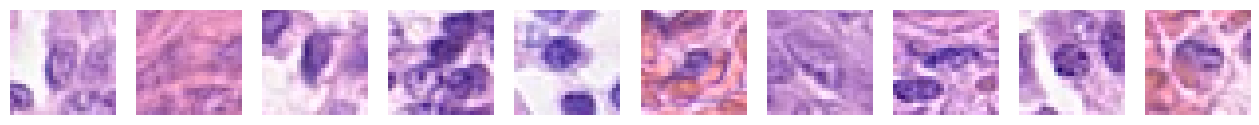

In [15]:
# Pull some random ass images 

from PIL import Image
from numpy.random import default_rng

imageCount = 400
# np.random_choice uses replacement while default_rng doesnt so the example batch gives no errors
rng = default_rng()

randomImages = dataset_mainData.loc[rng.choice(dataset_mainData.shape[0], size=imageCount, replace=False), 'ImageName']
# randomImages = dataset_mainData['ImageName']
fileLocation = './data/patch_images/'
images = []

for imageFilename in randomImages:
    # Import image as an 3d array where the first two dimensions are the pixels, 27 by 27 resolution images
    # and then the third dimension contains rgb values of each pixel (so each pixel has an array of length 3 with the colour info)
    # Therefore, images is a list of 3 dimensional arrays
    imageArray = np.asarray(Image.open(fileLocation + imageFilename))
    images.append(imageArray)

# Show first ten images i guess
plt.figure(figsize=(16,4))
for i, image in enumerate(images[:10]):
    plt.subplot(1,10,i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [16]:
# Find isCancerous for all the random images we pulled and put it into a dataframe
# basically df_Y

classOfRandomImages = dataset_mainData.loc[dataset_mainData['ImageName'].isin(randomImages)]
classOfRandomImages = classOfRandomImages['isCancerous']
classOfRandomImages

58      0
102     0
152     0
156     0
163     0
       ..
9797    0
9806    0
9814    0
9838    0
9884    1
Name: isCancerous, Length: 400, dtype: int64

In [17]:
# Logistic regressor likes np.arrays
images = np.array(images)
classOfRandomImages = np.array(classOfRandomImages)

In [18]:
# Converts the images from 3 d arrays into a 2 d array because logistic regressor only supports up to two dimensions
# Therefore each image gets flattened into a single string of numbers
images = images.reshape(len(images), 27*27*3)

In [19]:
# Do train test split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, classOfRandomImages, test_size=0.2, random_state=0)

In [20]:
# Fit a sample model

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler

# While it may be bad to suppress warnings globally we will be testing regularisation
# knowing whether the models converge or not won't matter in the end
simplefilter('ignore', ConvergenceWarning)

# It is advised that stochastic gradient solvers are more efficient with large, high dimension datasets
base1 = make_pipeline(MinMaxScaler(), LogisticRegression(solver='saga'))
base1.fit(X_train, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(solver='saga'))])

In [21]:
# Performance metrics

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

def perf(model):
    print(f"Training R2 accuracy: {model.score(X_train, Y_train)}")
    print(f"Testing R2 Accuracy: {model.score(X_test, Y_test)}")
    print(f"F1 Score: {f1_score(Y_test, model.predict(X_test))}")
    print(f"Confusion matrix:\n{confusion_matrix(Y_test, model.predict(X_test))}")
    return

In [22]:
# Perf metrics from base model 1

perf(base1)

Training R2 accuracy: 0.925
Testing R2 Accuracy: 0.5125
F1 Score: 0.3389830508474576
Confusion matrix:
[[31 18]
 [21 10]]


In [23]:
# Polynomial model

%%script

from sklearn.preprocessing import PolynomialFeatures

# Scale after polynomial features to avoid bugs
base2 = make_pipeline(PolynomialFeatures(), MinMaxScaler(), LogisticRegression())
base2.fit(X_train, Y_train)


UsageError: Line magic function `%%script` not found.


In [24]:
# Perf metrics from base model 2

perf(base2)

NameError: name 'base2' is not defined

In [25]:
# Neural model

from sklearn.neural_network import MLPClassifier

base3 = make_pipeline(MinMaxScaler(), MLPClassifier())
base3.fit(X_train, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpclassifier', MLPClassifier())])

In [26]:
# Perf metrics from base model 3

perf(base3)

Training R2 accuracy: 0.878125
Testing R2 Accuracy: 0.4875
F1 Score: 0.2807017543859649
Confusion matrix:
[[31 18]
 [23  8]]


In [ ]:
# Hypertuning linear model

from sklearn.model_selection import GridSearchCV

# There are no learning rate parameters for LogisticRegressor() even when using stochastic gradient descient
parameters = {
    'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C'       : np.logspace(-3, 3, 7),
}

hyper1 = GridSearchCV(base1, param_grid=parameters, scoring='accuracy', refit=True)
hyper1.fit(X_train, Y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [31]:
# Get hypertuning results helper function

def hypertune(model):
    print(f"Tuned hyperparameters: {model.best_params_}")
    print(f"Accuracy: {model.best_score_}")
    return

In [ ]:
hypertune(hyper1)

Tuned hyperparameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l1'}
Accuracy: 0.584375


In [ ]:
perf(hyper1)

Training R2 accuracy: 0.584375
Testing R2 Accuracy: 0.5375
F1 Score: 0.0
Confusion matrix:
[[43  0]
 [37  0]]


In [29]:
# Hypertune neural network model

from sklearn.model_selection import GridSearchCV


parameters3 = {
    'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05],
    'mlpclassifier__learning_rate': ['constant','adaptive']
}

hyper3 = GridSearchCV(base3, param_grid=parameters3, scoring='accuracy', refit=True)
hyper3.fit(X_train, Y_train)



GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('mlpclassifier', MLPClassifier())]),
             param_grid={'mlpclassifier__activation': ['tanh', 'relu'],
                         'mlpclassifier__alpha': [0.0001, 0.05],
                         'mlpclassifier__hidden_layer_sizes': [(10, 30, 10),
                                                               (20,)],
                         'mlpclassifier__learning_rate': ['constant',
                                                          'adaptive'],
                         'mlpclassifier__solver': ['sgd', 'adam']},
             scoring='accuracy')

In [32]:
hypertune(hyper3)
perf(hyper3)

Tuned hyperparameters: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (20,), 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__solver': 'adam'}
Accuracy: 0.584375
Training R2 accuracy: 0.86875
Testing R2 Accuracy: 0.55
F1 Score: 0.3571428571428571
Confusion matrix:
[[34 15]
 [21 10]]
